In [1]:
# %% load the required modules
import os
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from collections import defaultdict, Counter
import mysql.connector
import connect_sql

# SSM related modules
#import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)
import ssm
from ssm.util import find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap
import seaborn as sns

# hilber transform
from scipy.signal import hilbert

# visualize the tpm as a directed graph
import pygraphviz as pgv


/apps/conda/yd169/envs/dev-hmm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
## read_sql: query db_emorep and read in the dot products (emotion scores) 
# of emotion map and resting state fMRI data
db_con = connect_sql._DbConnect()
db_con.con_server()

# for querying everything
# query = """
#     select 
#     subj_id, task_id, volume, 
#     emo_amusement, emo_anger, emo_anxiety, emo_awe,   emo_calmness,
#     emo_craving, emo_disgust,emo_excitement, emo_fear, emo_horror,
#     emo_joy, emo_neutral,emo_romance, emo_sadness, emo_surprise, 
#     label_max 
#     from tbl_dotprod_emorep_202312"""
    
query = """

select 
a.subj_id, a.fsl_task_id,  a.volume,
    a.emo_amusement, a.emo_anger, a.emo_anxiety, a.emo_awe, a.emo_calmness,
    a.emo_craving, a.emo_disgust, a.emo_excitement, a.emo_fear, a.emo_horror,
    a.emo_joy, a.emo_neutral, a.emo_romance, a.emo_sadness, a.emo_surprise,
    a.label_max
from tbl_dotprod_emorep a  
join ref_sess_task b on a.subj_id=b.subj_id and a.sess_id=b.sess_id 
where a.fsl_task_id=1 and b.task_id=1

"""  

with db_con.con_cursor() as cur:
    cur.execute(query)
    query_results = cur.fetchall()

# close the connection to the data base
db_con.con_close()

In [4]:
# %% convert query_results into a pandas dataframe
emo_rest = pd.DataFrame(
    query_results, columns=['subj_id', 'fsl_task_id', 'volume',
                         'emo_amusement', 'emo_anger', 'emo_anxiety', 
                         'emo_awe',   'emo_calmness','emo_craving', 
                         'emo_disgust','emo_excitement', 'emo_fear', 
                         'emo_horror', 'emo_joy', 'emo_neutral',
                         'emo_romance', 'emo_sadness', 'emo_surprise', 'label_max'])

# print(emo_rest.head())

In [5]:
# %%
#############################################################################
## calculate and plot the raw frequency distribution
#############################################################################
emo_sequence = emo_rest['label_max']

emo_score_df=emo_rest.drop(['subj_id','fsl_task_id','volume','label_max'], index=None,axis=1)

#combined_array=emo_rest.values
# Extracting column names before reshaping
column_names = emo_score_df.columns.tolist()


emo_labels=[]
for column_name in column_names:
    emo_label=column_name.split("_")[1]
    emo_labels.append(emo_label)


# print(emo_sequence.head())

# print(emo_labels)

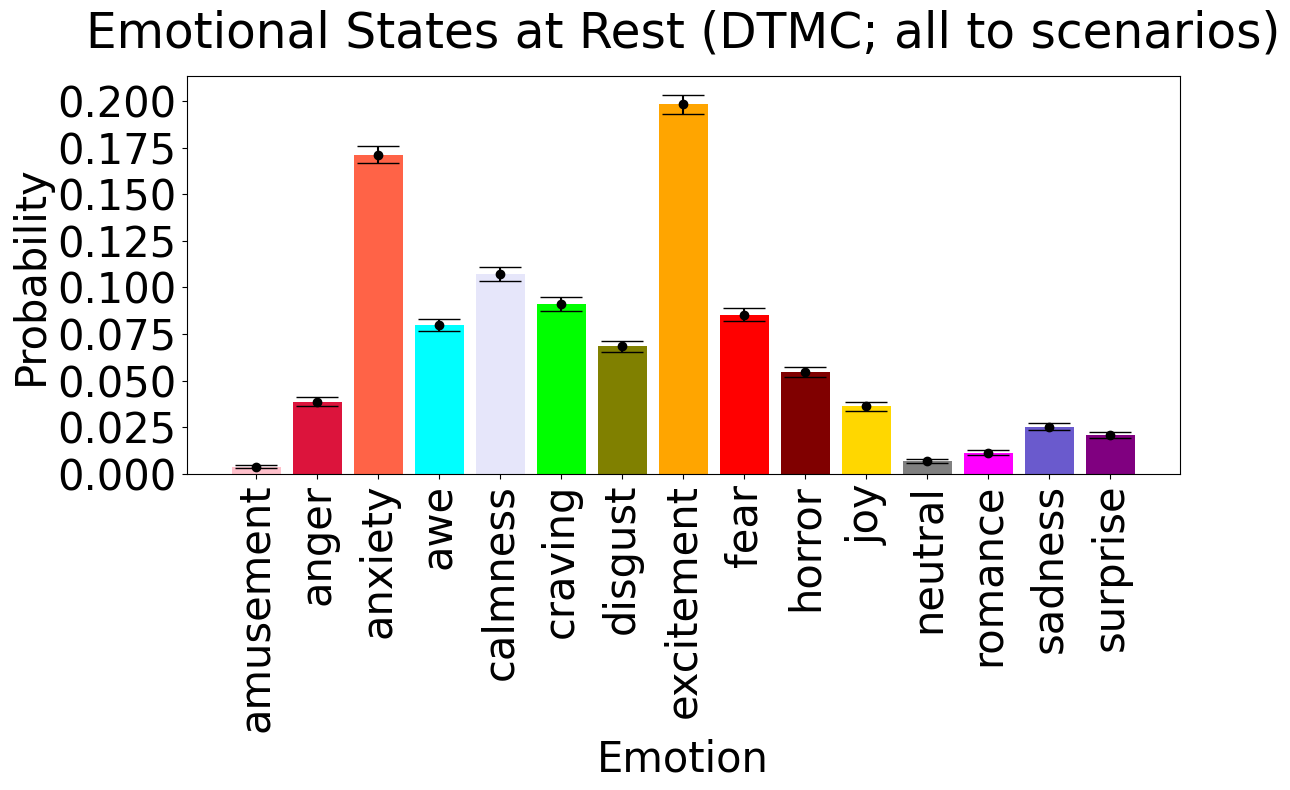

In [6]:
# Create a mapping from string values to numerical categories
categories = {val: idx for idx, val in enumerate(sorted(set(emo_sequence)))}

# Convert string values to numerical categories
numerical_emo_sequence = np.array([categories[val] for val in emo_sequence])

# Get unique numerical categories and their counts
unique_categories, counts = np.unique(numerical_emo_sequence, return_counts=True)

num_states=len(unique_categories)

colors= [
    'pink', 'crimson','tomato','cyan','lavender',
    'lime','olive','orange','red','maroon',
    'gold','grey','magenta','slateblue','purple'
][:len(unique_categories)]


total_samples = numerical_emo_sequence.shape[0]
probabilities = counts / total_samples


# Define the number of bootstrap samples
num_bootstrap_samples = 500

# Initialize an array to store bootstrap probabilities
bootstrap_probabilities = np.zeros((num_states, num_bootstrap_samples))

# Perform bootstrapping
for i in range(num_bootstrap_samples):
    # Generate a bootstrap sample
    bootstrap_sample_indices = np.random.choice(total_samples, total_samples, replace=True)
    bootstrap_sample_counts = np.bincount(numerical_emo_sequence[bootstrap_sample_indices], minlength=num_states)
    bootstrap_sample_probs = bootstrap_sample_counts / total_samples
    bootstrap_probabilities[:, i] = bootstrap_sample_probs

# Calculate confidence intervals
confidence_intervals = np.percentile(bootstrap_probabilities, [2.5, 97.5], axis=1)

# Plotting a histogram for each category with different colors
plt.figure(figsize=(12, 8))
for category, prob, color, ci in zip(unique_categories, probabilities, colors, confidence_intervals.T):
    plt.bar(category, prob, color=color, label=list(categories.keys())[list(categories.values()).index(category)])
    plt.errorbar(category, prob, yerr=[[prob - ci[0]], [ci[1] - prob]], fmt='o', color='black', capsize=15)

# Customize the plot labels and title
plt.xlabel('Emotion', fontsize=30)
plt.ylabel('Probability', fontsize=30)
plt.title('Emotional States at Rest (DTMC; all to scenarios)', fontsize=35, pad=20)
plt.xticks(np.arange(num_states), [emo_labels[cat] for cat in unique_categories], fontsize=30, rotation=90)
plt.yticks(fontsize=30)
plt.tight_layout()
plt.show()

# # Plotting a histogram for each category with different colors
# plt.figure(figsize=(15, 8))
# for category, prob, color in zip(unique_categories, probabilities, colors):
#     plt.bar(category, prob, color=color, label=list(categories.keys())[list(categories.values()).index(category)])

# # Customize the plot labels and title
# plt.xlabel('Emotion',fontsize=30)
# plt.ylabel('Frequency',fontsize=30)
# plt.title('Distribution of Emotional States at Rest (DTMC; scenarios)',fontsize=35,pad=20)
# # plt.xticks(unique_categories,[list(categories.keys())[list(categories.values()).index(cat)] for cat in unique_categories], 
# #            fontsize=35,rotation=90)
# plt.xticks(np.arange(num_states), emo_labels,fontsize=30,rotation=90)
# plt.yticks(fontsize=30)
# plt.tight_layout
# plt.show()

In [124]:
# Create a dictionary to map unique states to integers
states = sorted(set(emo_sequence))
state_indices = {state: idx for idx, state in enumerate(states)}

# Convert sequence of string states to a sequence of integer indices
indices_sequence = [state_indices[state] for state in emo_sequence]

# Calculate transition matrix from the sequence of states
num_states = len(states)
transition_matrix = np.zeros((num_states, num_states))

for i in range(len(indices_sequence) - 1):
    current_state = indices_sequence[i]
    next_state = indices_sequence[i + 1]
    transition_matrix[current_state][next_state] += 1

# Normalize transition matrix to obtain transition probabilities
transition_matrix /= transition_matrix.sum(axis=1, keepdims=True)


# Define the number of bootstrap samples
num_bootstrap_samples = 1000

# Initialize an array to store bootstrap transition matrices
bootstrap_transition_matrices = np.zeros((num_bootstrap_samples, num_states, num_states))

# Perform bootstrapping
for i in range(num_bootstrap_samples):
    # Generate a bootstrap sample
    bootstrap_sample_indices = np.random.choice(len(indices_sequence), len(indices_sequence), replace=True)
    bootstrap_transition_counts = np.zeros((num_states, num_states))
    
    # Calculate transition counts for the bootstrap sample
    for j in range(len(bootstrap_sample_indices) - 1):
        current_state = indices_sequence[bootstrap_sample_indices[j]]
        next_state = indices_sequence[bootstrap_sample_indices[j + 1]]
        bootstrap_transition_counts[current_state][next_state] += 1
    
    # Normalize transition counts to obtain a transition matrix
    bootstrap_transition_matrices[i] = bootstrap_transition_counts / bootstrap_transition_counts.sum(axis=1, keepdims=True)

# Print confidence intervals for each transition
for i in range(num_states):
    for j in range(num_states):
        print(f'Transition probability from {states[i]} to {states[j]}: {confidence_intervals_tpm[:, i, j]}')

KeyboardInterrupt: 

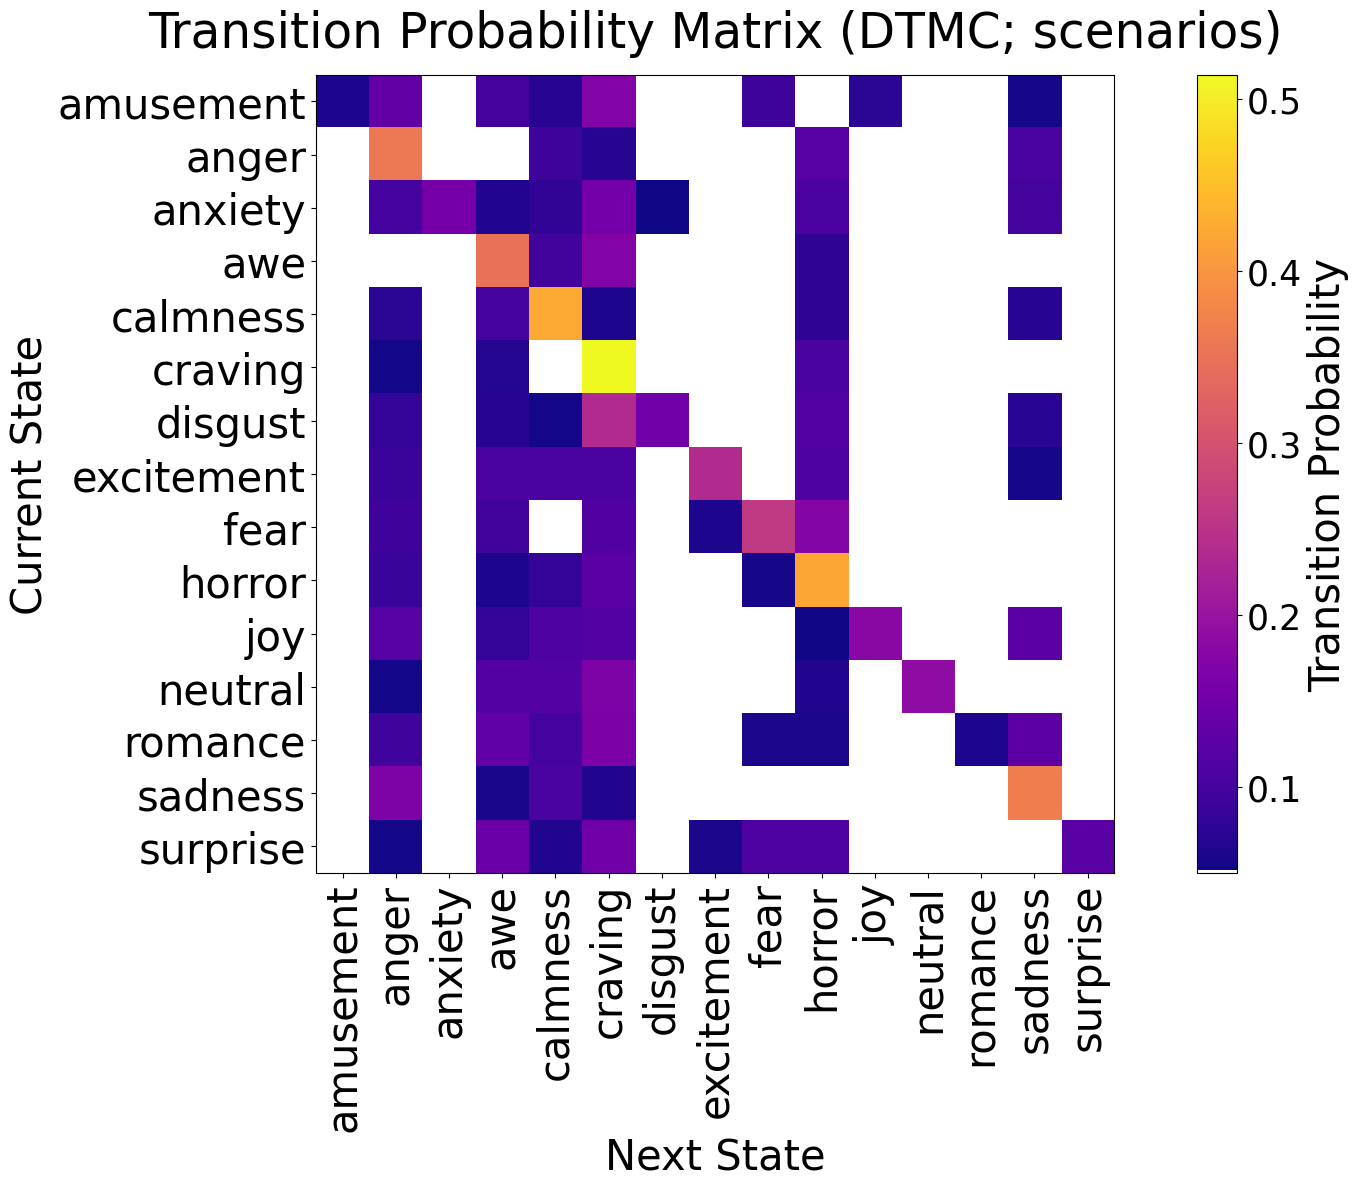

In [126]:
# Create a mask to threshold transition probabilities
threshold = 0.05
masked_matrix = np.ma.masked_where(transition_matrix < threshold, transition_matrix)

# Define a colormap for values above the threshold
cmap = plt.cm.plasma
tpm_colors = cmap(np.arange(cmap.N))
tpm_colors[0] = (1, 1, 1, 0.0)  # Set color for values below the threshold (transparent white)

new_cmap = LinearSegmentedColormap.from_list('truncated_cmap', tpm_colors)

# Visualize the thresholded transition probability matrix
plt.figure(figsize=(18, 12))
plt.imshow(masked_matrix, cmap=new_cmap, interpolation='nearest')
cbar = plt.colorbar()
cbar.set_label('Transition Probability', fontsize=30)
cbar.ax.tick_params(labelsize=25)

plt.title('Transition Probability Matrix (DTMC; scenarios)',fontsize=35,pad=20)
plt.xlabel('Next State',fontsize=30)
plt.ylabel('Current State',fontsize=30)
plt.xticks(np.arange(num_states), emo_labels,fontsize=30,rotation=90)
plt.yticks(np.arange(num_states), emo_labels,fontsize=30)
plt.tight_layout()
plt.show()

In [127]:

# Assuming you have already computed the transition_matrix
# Adjust num_labels if needed
num_labels = len(masked_matrix)

# # Define a list of colors
# colors = ['lightblue', 'lightgreen', 'lightyellow', 'lightpink', 'lightcyan', 
#           'lightcoral', 'lightsalmon', 'lightseagreen', 'lightskyblue', 'lightsteelblue',
#           'lightgrey', 'lightgoldenrodyellow', 'lightpink', 'lightgreen', 'lightblue']

# Create Directed graph
G = pgv.AGraph(directed=True)



# Add nodes to the graph with unique colors
for i in range(num_labels):
    G.add_node(i, label=emo_labels[i], style='filled', fillcolor=colors[i])
    G.node_attr['fontsize'] = '80'

# Add edges to the graph with transition probabilities as labels and widths
for i in range(num_labels):
    for j in range(num_labels):
        weight = masked_matrix[i][j]
        if weight > 0:
            # Set the width of the edge based on the transition probability
            width = 1 + 20 * weight  # Adjust the scaling factor as needed
            G.add_edge(i, j, color='blue', penwidth=width, arrowsize='2')
            #G.add_edge(i, j, label=f"{weight:.2f}", color='blue', penwidth=width, fontsize=60,arrowsize='3')


# Visualize the graph
G.layout(prog='dot')
G.graph_attr['size'] = '10,10!'


#G.graph_attr['size'] = '10,10'
output_file = "transition_graph_colored_states_width_all_to_scenarios.png"
G.draw(output_file)

In [128]:
######################## Ignore everything below this 


#  %% Examine the autocorrelation in the emotion score time series 
######################################################################################
# Examine the autocorrelation in the emotion score time series 
#######################################################################################
emo_score_df=emo_rest.drop(['subj_id','fsl_task_id','volume','label_max'], index=None,axis=1)

#combined_array=emo_rest.values
# Extracting column names before reshaping
column_names = emo_score_df.columns.tolist()

num_sample=int(emo_score_df.shape[0]/240)

# Convert the DataFrame to a 3D NumPy array
emo_score_by_participant = emo_score_df.values.reshape (num_sample, 15, 240)

emo_score_by_participant=emo_score_by_participant.astype(np.float64)

# Displaying the shape of the resulting 3D NumPy array
print("Shape of 3D NumPy array:", emo_score_by_participant.shape)




Shape of 3D NumPy array: (103, 15, 240)


In [129]:

import numpy as np
from scipy.signal import hilbert

# Assuming your data is stored in a 3D numpy array called 'data'
# Dimensions: (participants, num_ts, time_points)
# Here's a sample random data for illustration
num_participants = emo_score_by_participant.shape[0]
num_ts = emo_score_by_participant.shape[1]
time_points = emo_score_by_participant.shape[2]

# Initialize an array to store instantaneous power
emo_insta_power = np.zeros((num_participants, num_ts, time_points))

# Compute instantaneous power using Hilbert transform
for participant in range(num_participants):
    for ts in range(num_ts):
        analytic_signal = hilbert(emo_score_by_participant[participant, ts, :])
        emo_insta_power[participant, ts, :] = np.abs(analytic_signal)**2

emo_power_reshaped=emo_insta_power.reshape(-1,num_ts)

In [130]:
# # Calculating lag-one autocorrelation for each time series for each participant
# autocorrelation_results = []

# for participant in emo_score_by_participant:
#     participant_autocorrelation = []
#     for series in participant:
#         # Calculate lag-one autocorrelation for each series
#         autocorr = np.corrcoef(series[:-1], series[1:])[0, 1]
#         participant_autocorrelation.append(autocorr)
    
#     autocorrelation_results.append(participant_autocorrelation)

# # Convert results to a Pandas DataFrame for better organization
# emo_autocorr = pd.DataFrame(autocorrelation_results)
# emo_autocorr.index.name = 'Participant'
# emo_autocorr.columns = column_names

# print(emo_autocorr)

In [ ]:
# # Plotting histograms for each time series with different colors
# plt.figure(figsize=(12, 8))

# colors = plt.cm.get_cmap('tab20', 15)  # Choosing a colormap with 15 colors

# for i, column in enumerate(emo_autocorr.columns):
#     # Extracting the name of the time series from the column label
#     series_name = column.split('_')[1]  # Assuming column names are in the format 'TimeSeries_X'
    
#     # Plotting histogram with the title containing the time series name
#     plt.hist(emo_autocorr[column], bins=20, alpha=0.7, label=f'TimeSeries_{i+1}', color=colors(i))
#     plt.title(f'Histogram of Lag-one Autocorrelation for Time Series {series_name}')
#     plt.xlabel('Lag-one Autocorrelation')
#     plt.ylabel('Frequency')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

In [131]:
# %% plot the emo_scores
# Set the parameters of the HMM
time_bins = 480   # number of time bins
num_states = 15    # number of discrete states
obs_dim = 15       # dimensionality of observation

emo_scores=emo_score_df.values
emo_scores=emo_scores.astype(np.float64)

emo_scores.shape[0]

24720

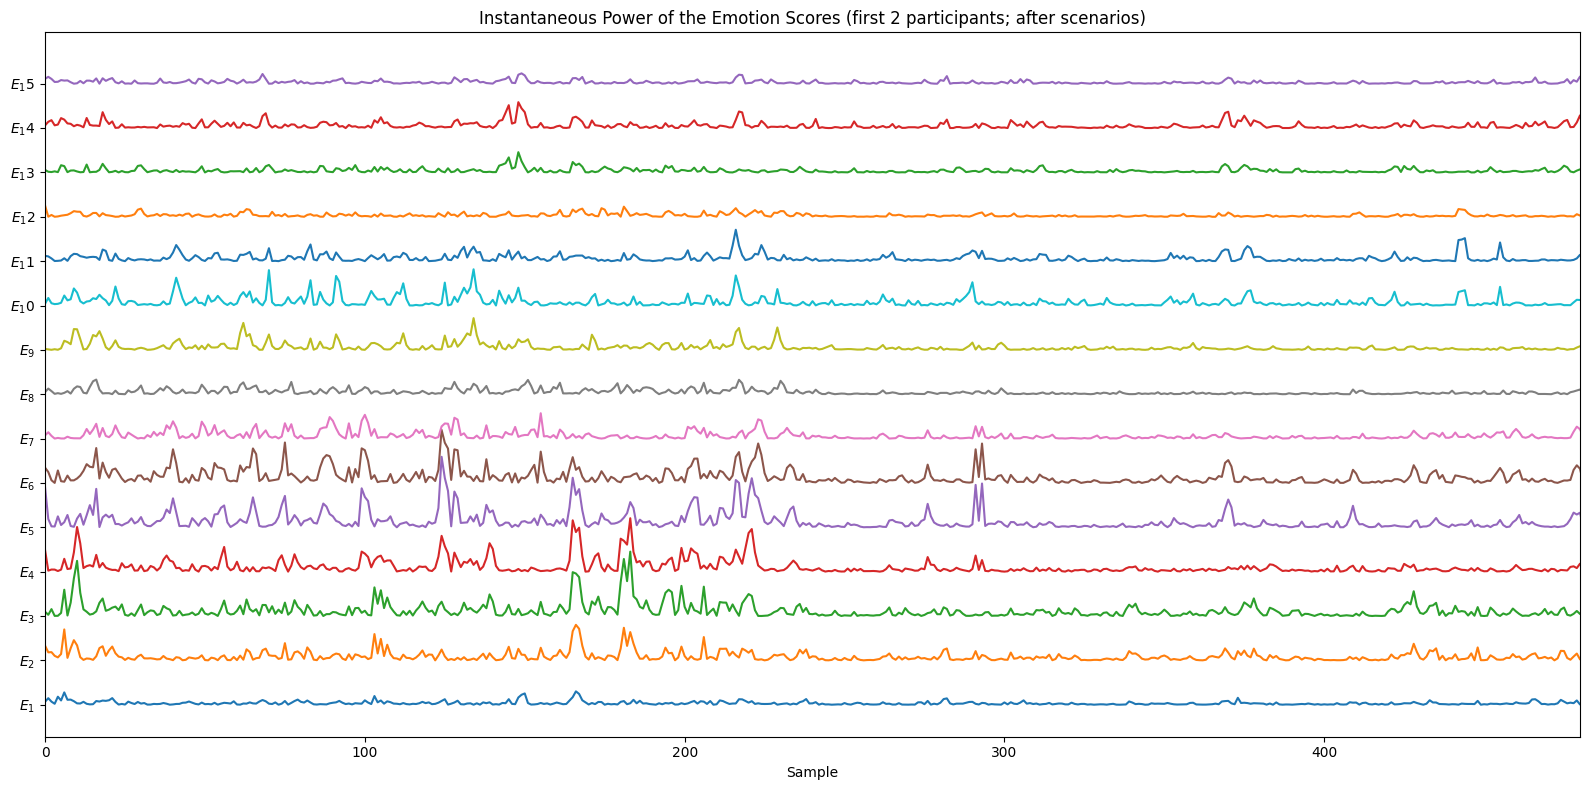

In [132]:
colors= [
    'pink', 'crimson','tomato','cyan','lavender',
    'lime','olive','orange','red','maroon',
    'gold','grey','magenta','blue','purple'
][:len(unique_categories)]

# plot the emotion score
# Plot the data and the smoothed data
lim = 1.005 * abs(emo_power_reshaped).max()
plt.figure(figsize=(16, 8))

for d in range(obs_dim):
    plt.plot(2*emo_power_reshaped[:,d] + lim * d,mfc=colors[d])

plt.xlim(0, time_bins)
plt.xlabel("Sample")
plt.yticks(lim * np.arange(obs_dim), ["$E_{}$".format(d+1) for d in range(obs_dim)])
#plt.yticks(lim * np.arange(obs_dim), emo_labels[d])

#plt.yticks(np.arange(num_states), emo_labels,fontsize=25)
#plt.title("Emotion Scores at Rest first 2 participants (after scenarios)")
plt.title("Instantaneous Power of the Emotion Scores (first 2 participants; after scenarios)")

plt.tight_layout()


In [133]:
# Compute instantaneous power for each time series
insta_powers = np.zeros((emo_scores.shape[0],num_states))
for i in range(num_states):
    analytic_signal = hilbert(emo_scores[:,i])
    insta_powers[:,i] = np.abs(analytic_signal)**2

In [34]:
emo_scores[:,0]

array([ 457.54, -526.02,  -85.44, ...,  174.88,   86.8 ,   72.21])

LP: -5026978.1: 100%|██████████| 100/100 [01:02<00:00,  1.60it/s]


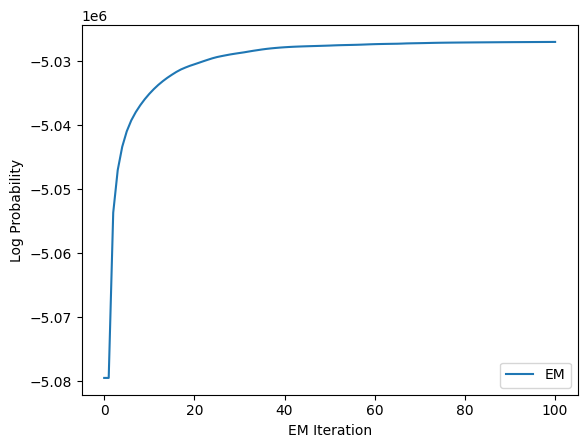

In [134]:
N_iters = 100
## testing the constrained transitions class
hmm = ssm.HMM(num_states, obs_dim, transitions="standard", observations="gaussian")

hmm_lls = hmm.fit(emo_power_reshaped, method="em", num_iters=N_iters, init_method="kmeans")

plt.plot(hmm_lls, label="EM")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")
plt.show()

most_likely_states = hmm.most_likely_states(emo_power_reshaped)


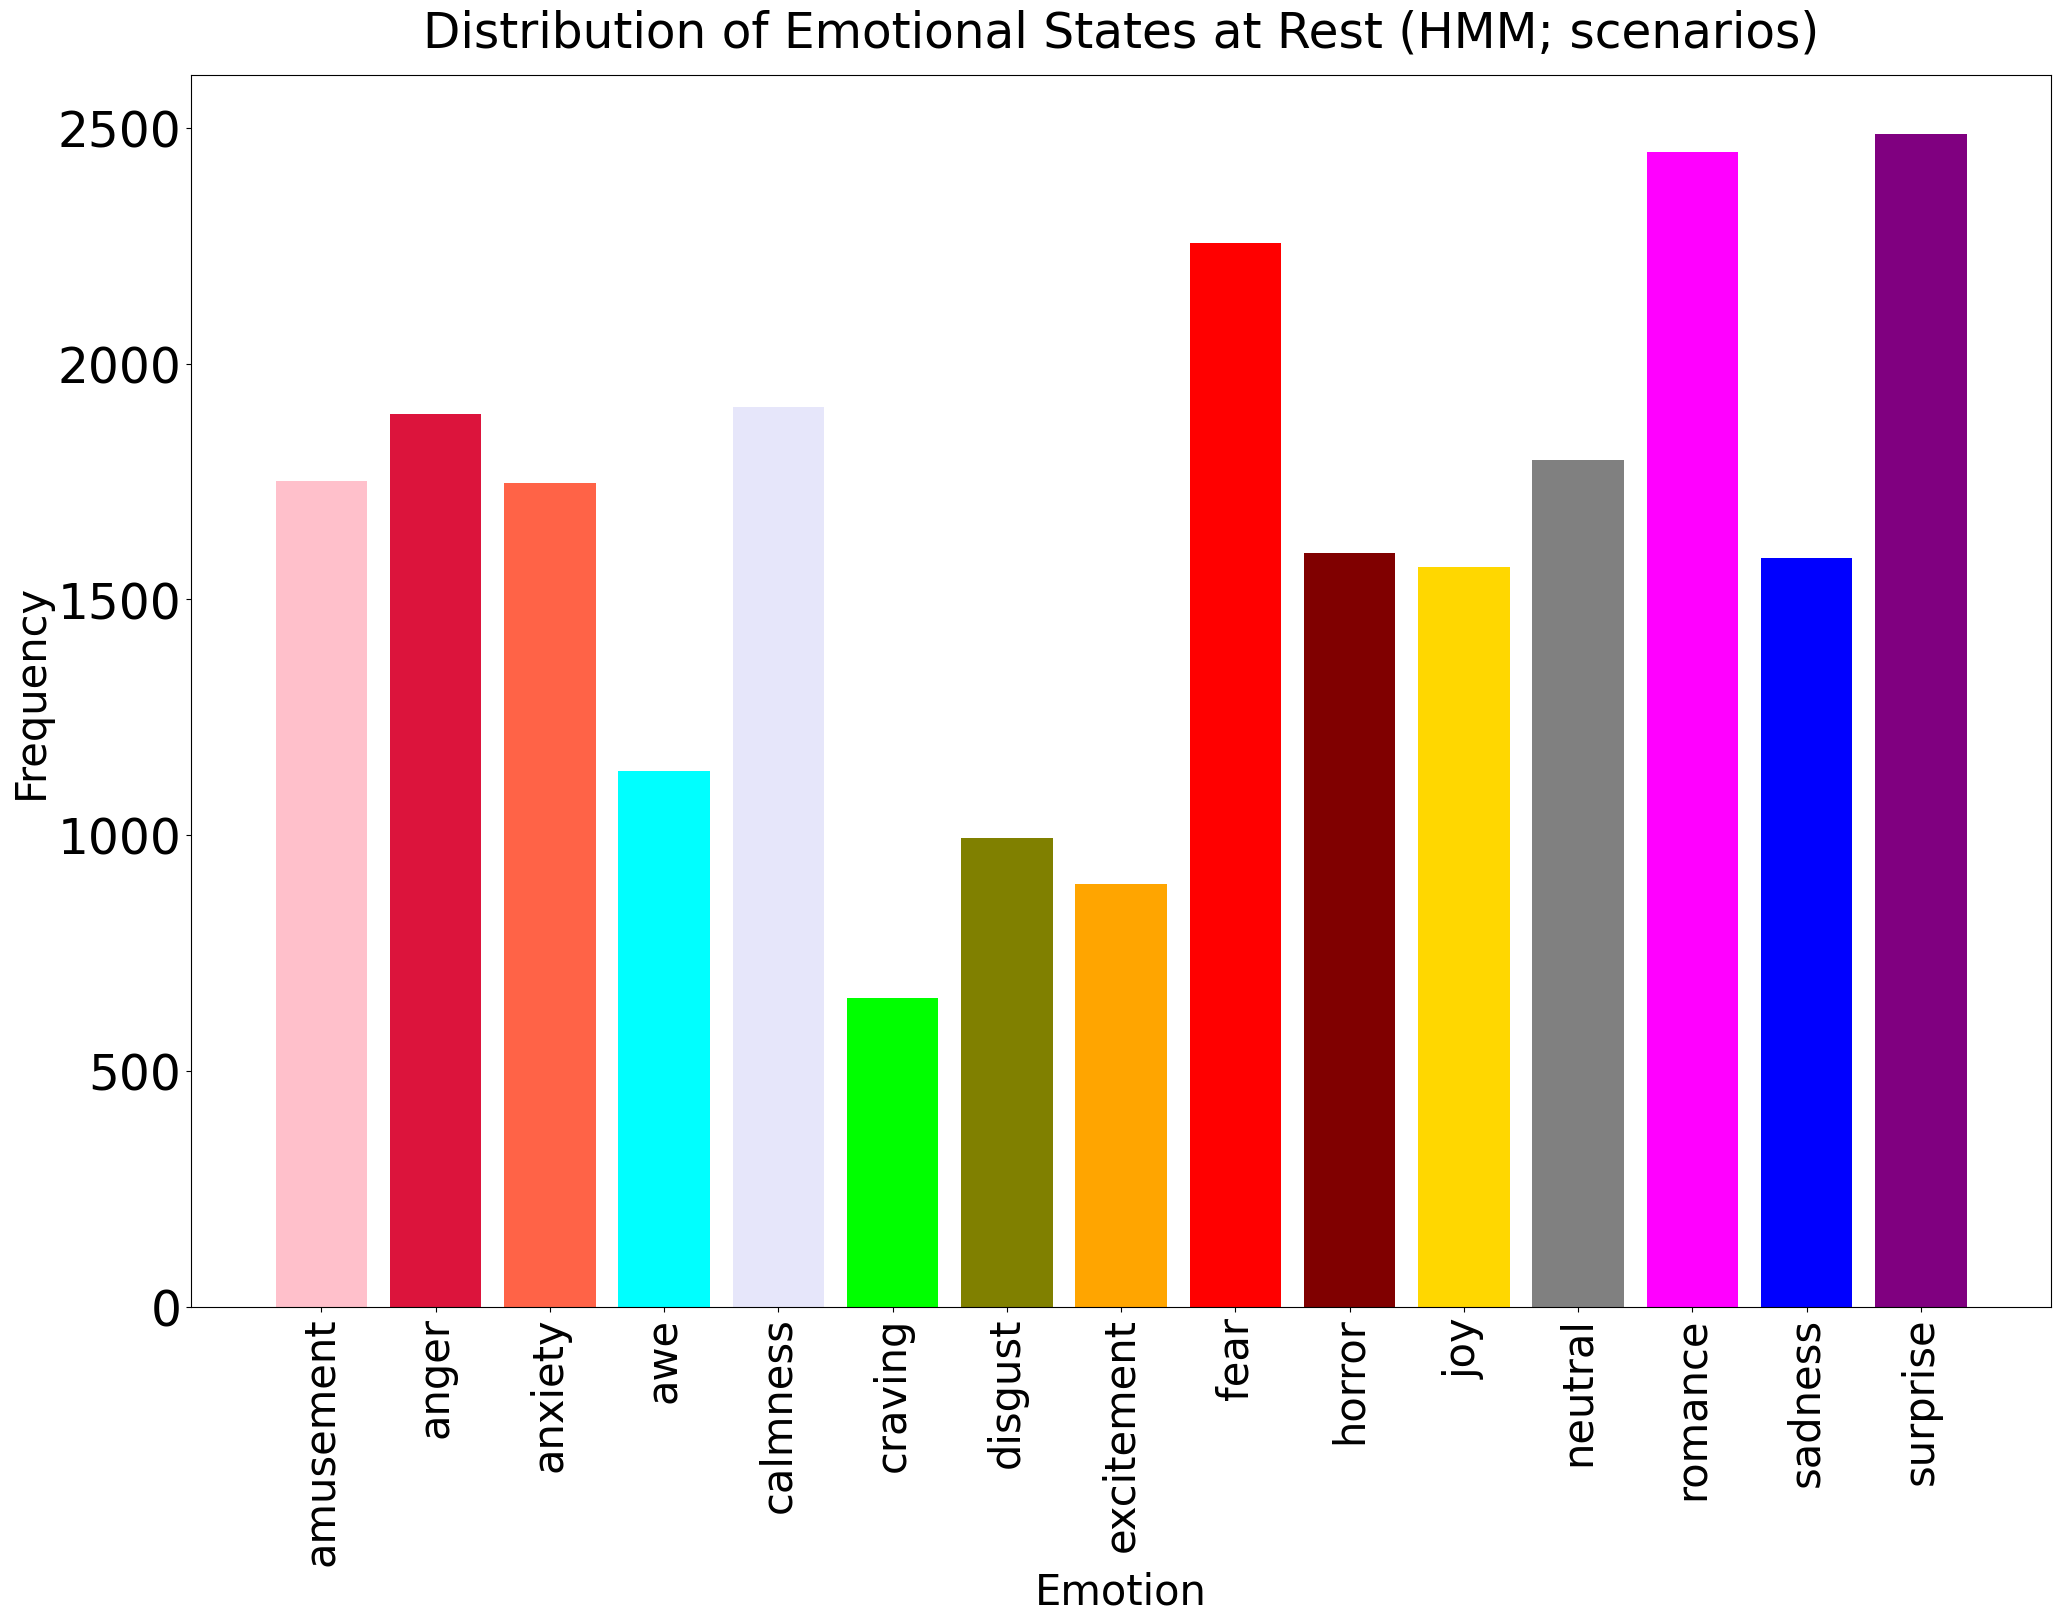

In [136]:
#emo_sequence = combined_df['label_max']
emo_sequence = most_likely_states

#print(emo_sequence.head())

# Create a mapping from string values to numerical categories
categories = {val: idx for idx, val in enumerate(sorted(set(emo_sequence)))}

# Convert string values to numerical categories
numerical_emo_sequence = np.array([categories[val] for val in emo_sequence])

# Get unique numerical categories and their counts
unique_categories, counts = np.unique(numerical_emo_sequence, return_counts=True)


# Plotting a histogram for each category with different colors
plt.figure(figsize=(24, 16))
for category, count, color in zip(unique_categories, counts, colors):
    plt.bar(category, count, color=color, label=list(categories.keys())[list(categories.values()).index(category)])

# Customize the plot labels and title
plt.xlabel('Emotion',fontsize=30)
plt.ylabel('Frequency',fontsize=30)
plt.title('Distribution of Emotional States at Rest (HMM; scenarios)',fontsize=35,pad=20)
plt.xticks(np.arange(num_states), emo_labels,fontsize=30,rotation=90)
# plt.xticks(unique_categories,[list(categories.keys())[list(categories.values()).index(cat)] for cat in unique_categories], 
#            fontsize=35,rotation=90)

plt.yticks(fontsize=35)
plt.tight_layout
#plt.legend(fontsize=15)
plt.show()


In [137]:
# %% TPM from inferred emotional states
# Create a dictionary to map unique states to integers
#import numpy as np

states = sorted(set(emo_sequence))
state_indices = {state: idx for idx, state in enumerate(states)}

# Convert sequence of string states to a sequence of integer indices
indices_sequence = [state_indices[state] for state in emo_sequence]

# Calculate transition matrix from the sequence of states
num_states = len(states)
transition_matrix = np.zeros((num_states, num_states))

for i in range(len(indices_sequence) - 1):
    current_state = indices_sequence[i]
    next_state = indices_sequence[i + 1]
    transition_matrix[current_state][next_state] += 1

# Normalize transition matrix to obtain transition probabilities
transition_matrix /= transition_matrix.sum(axis=1, keepdims=True)


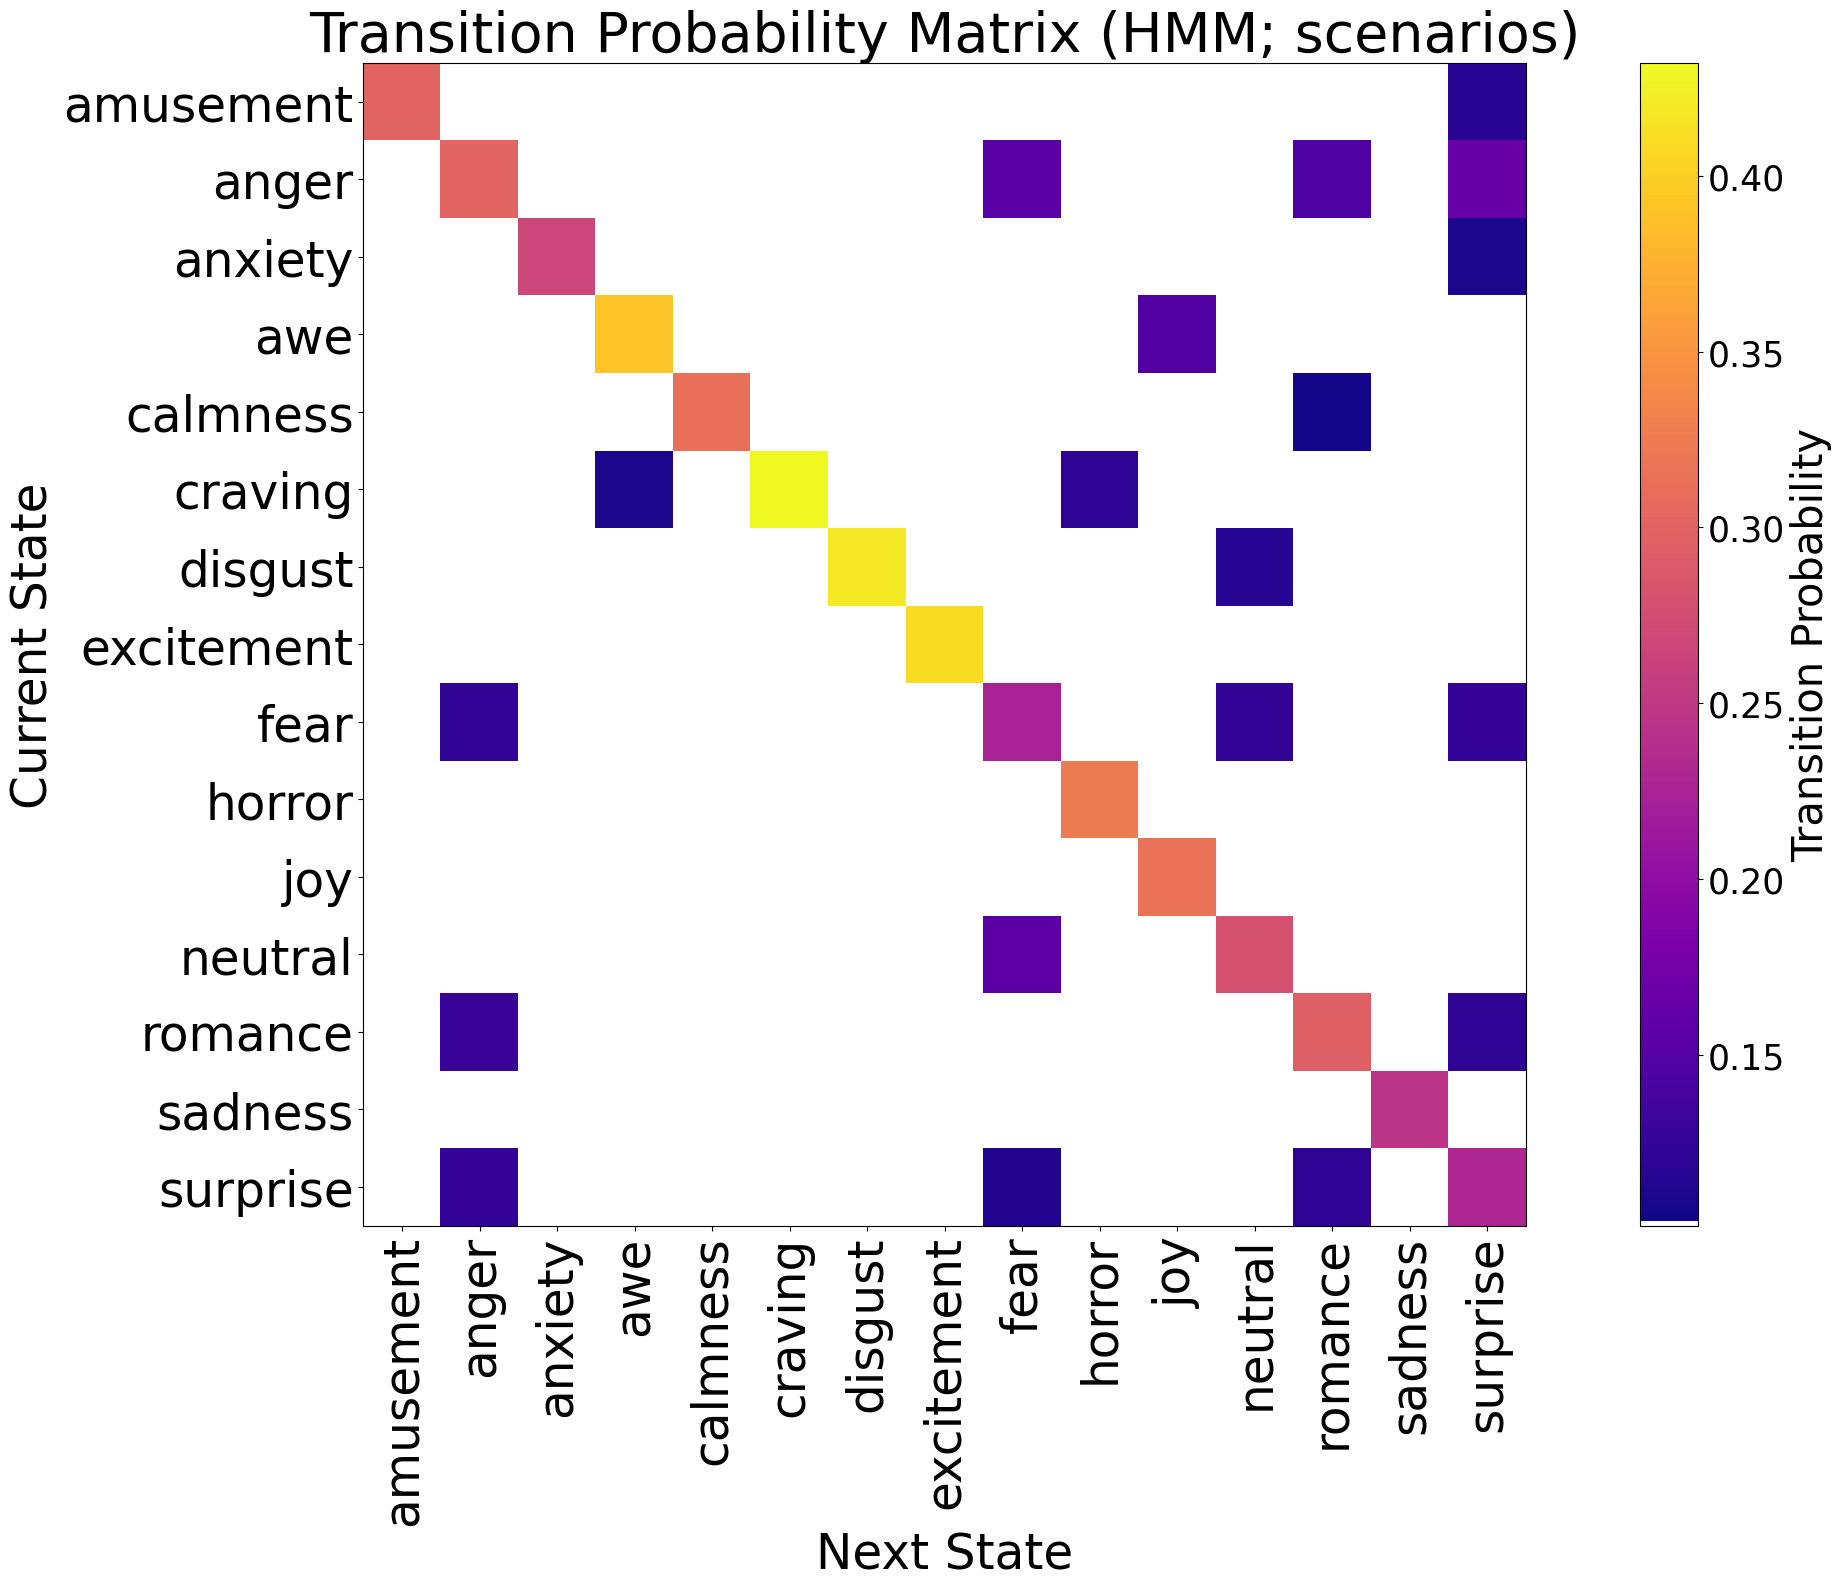

In [138]:
#transition_matrix=hmm.transitions.transition_matrix

# Create a mask to threshold transition probabilities
threshold = 0.1
masked_matrix = np.ma.masked_where(transition_matrix < threshold, transition_matrix)

# Define a colormap for values above the threshold
cmap = plt.cm.plasma
tpm_colors = cmap(np.arange(cmap.N))
tpm_colors[0] = (1, 1, 1, 0.0)  # Set color for values below the threshold (transparent white)

new_cmap = LinearSegmentedColormap.from_list('truncated_cmap', tpm_colors)

# Visualize the thresholded transition probability matrix
plt.figure(figsize=(24, 16))
plt.imshow(masked_matrix, cmap=new_cmap, interpolation='nearest')
cbar = plt.colorbar()
cbar.set_label('Transition Probability', fontsize=30)
cbar.ax.tick_params(labelsize=25)

emo_labels=[]
for column_name in column_names:
    emo_label=column_name.split("_")[1]
    emo_labels.append(emo_label)

plt.title('Transition Probability Matrix (HMM; scenarios)',fontsize=40)
plt.xlabel('Next State',fontsize=35)
plt.ylabel('Current State',fontsize=35)
plt.xticks(np.arange(num_states), emo_labels,fontsize=35,rotation=90)
plt.yticks(np.arange(num_states), emo_labels,fontsize=35)
plt.tight_layout()
plt.show()


In [141]:
# Assuming you have already computed the transition_matrix
# Adjust num_labels if needed
num_labels = len(masked_matrix)

# # Define a list of colors
# colors = ['lightblue', 'lightgreen', 'lightyellow', 'lightpink', 'lightcyan', 
#           'lightcoral', 'lightsalmon', 'lightseagreen', 'lightskyblue', 'lightsteelblue',
#           'lightgrey', 'lightgoldenrodyellow', 'lightpink', 'lightgreen', 'lightblue']

# Create Directed graph
G = pgv.AGraph(directed=True)



# Add nodes to the graph with unique colors
for i in range(num_labels):
    G.add_node(i, label=emo_labels[i], style='filled', fillcolor=colors[i])
    G.node_attr['fontsize'] = '80'

# Add edges to the graph with transition probabilities as labels and widths
for i in range(num_labels):
    for j in range(num_labels):
        weight = masked_matrix[i][j]
        if weight > 0:
            # Set the width of the edge based on the transition probability
            width = 1 + 20 * weight  # Adjust the scaling factor as needed
            G.add_edge(i, j, color='blue', penwidth=width, arrowsize='2')
            #G.add_edge(i, j, label=f"{weight:.2f}", color='blue', penwidth=width, fontsize=60,arrowsize='3')


# Visualize the graph
G.layout(prog='dot')
G.graph_attr['size'] = '10,10!'


#G.graph_attr['size'] = '10,10'
output_file = "HMM_transition_graph_colored_states_width_all_to_scenarios.png"
G.draw(output_file)

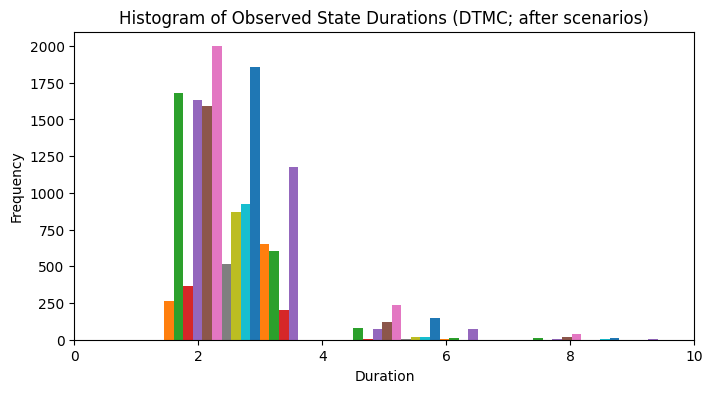

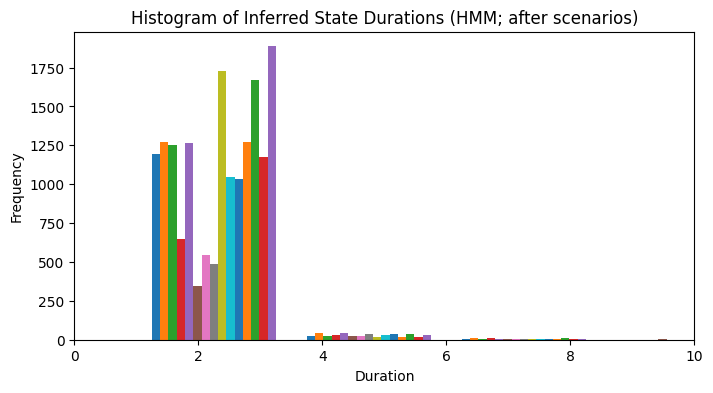

In [142]:
emo_sequence = emo_rest['label_max']

true_state_list, true_durations = ssm.util.rle(emo_sequence)
inferred_state_list, inferred_durations = ssm.util.rle(most_likely_states)

# Rearrange the lists of durations to be a nested list where
# the nth inner list is a list of durations for state n
true_durs_stacked = []
inf_durs_stacked = []
for s in range(num_states):
    true_durs_stacked.append(true_durations[true_state_list == s])
    inf_durs_stacked.append(inferred_durations[inferred_state_list == s])
    
fig = plt.figure(figsize=(8, 4))
plt.hist(true_durs_stacked, label=['state ' + str(s) for s in range(num_states)])
plt.xlabel('Duration')
plt.ylabel('Frequency')
plt.xlim(0, 10)
#plt.legend()
plt.title('Histogram of Observed State Durations (DTMC; after scenarios)')

fig = plt.figure(figsize=(8, 4))
plt.hist(inf_durs_stacked, label=['state ' + str(s) for s in range(num_states)])
plt.xlabel('Duration')
plt.ylabel('Frequency')
plt.xlim(0, 10)
#plt.legend()
plt.title('Histogram of Inferred State Durations (HMM; after scenarios)')

plt.show()